# New school VS Old School HipHop Which is better? Is there any difference?

You can often hear that there is a difference between old school & new school Hip Hop, many argue that old school Hip Hop is better and many argue otherwise.

![alt text](https://cdn-images-1.medium.com/max/800/1*X9WzT11cauXIlwL7tGmpvw.jpeg "Logo Title Text 1")


Today I'll try to answer the first question - Is there a difference between old school & new school Hip Hop?<br/>
I'll focus on the difference in the lyrics.


I'll start with some simple lyrics analysis, then I'll try to teach a model to distinguish between old school and new school lyrics and finally we will interpret the model's decisions.


For this experiment I picked around 60 rappers, some from the old school and some from the new school.<br/>
I used the [Genius API](https://docs.genius.com/) to extract the songs' webpages and then html parsers to extract the lyrics  themselves.<br/>
I've built a wrapper around the API for this use, you can check it out in this [GitHub page]()



#### Enough talking, let's start working:

## Analysis

In [1]:
# Load our modules and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
# %matplotlib inline
sns.set()
np.random.seed(1)

In [2]:
data = pd.read_excel(r'lyrics.xlsx')
data.head()

,song_url,lyrics,artist,rapper_type
0,https://genius.com/Jay-z-03-bonnie-and-clyde-l...,"\n\n[Intro: Jay Z]\nUhh, uhh, uhh\nYou ready, ...",2pac,old_school_rappers
1,https://genius.com/2pac-16-on-death-row-lyrics,\n\n[Intro]\nDeath Row\nThat's where mothafuck...,2pac,old_school_rappers
2,https://genius.com/Bknappbeats-16-on-death-row...,\n\n[Verse 1]\nI'm caught up in this sickness\...,2pac,old_school_rappers
3,https://genius.com/2pac-187-on-a-hook-remix-ly...,"\n\n[Hook: C-Bo] (2X)\nWest side, it's 187 on ...",2pac,old_school_rappers
4,https://genius.com/2pac-1995-police-station-te...,"\n\nWoman – Sir, will you raise your right han...",2pac,old_school_rappers


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5709 entries, 0 to 5708
Data columns (total 4 columns):
song_url       5709 non-null object
lyrics         5709 non-null object
artist         5709 non-null object
rapper_type    5709 non-null object
dtypes: object(4)
memory usage: 223.0+ KB


## Let's look at duplicate data:
Songs may have more than one rapper, so we can encounter duplicates.<br/>
More than one rapper with the same lyrics and song url (If it's the same song it should have tha same url for lyrics).

I'll group songs with the same lyrics. If there is more than one unique url for a unique lyrics then I would want to take further look:

In [4]:
for i, same_lyrics in data.groupby('lyrics'):
    if len(set(same_lyrics['song_url'])) > 1:
        for _, row in same_lyrics.iterrows():
            print(row['song_url'])
        print('---------')

https://genius.com/Nas-cherry-wine-single-art-annotated
https://genius.com/Gordon-parks-a-great-day-in-hip-hop-lyrics
https://genius.com/Gordon-parks-a-great-day-in-hip-hop-lyrics
https://genius.com/Lil-jon-and-the-east-side-boyz-certified-crunk-da-remix-booklet-annotated
https://genius.com/Gordon-parks-a-great-day-in-hip-hop-lyrics
https://genius.com/Wu-tang-clan-enter-the-wu-tang-36-chambers-artwork-lyrics
https://genius.com/Gordon-parks-a-great-day-in-hip-hop-lyrics
https://genius.com/Redman-dare-iz-a-darkside-album-art-annotated
https://genius.com/Fashion-genius-fit-of-the-day-6-14-14-annotated
https://genius.com/Chance-the-rapper-10-day-outfit-10-day-listening-party-lyrics
https://genius.com/Chance-the-rapper-acid-rap-outfit-sxsw-2013-annotated
https://genius.com/Rene-marban-chance-the-rapper-european-tour-shirt-lyrics
https://genius.com/Chance-the-rapper-chance-the-rapper-illinois-university-poster-lyrics
https://genius.com/Rock-em-apparel-chance-the-rapper-sock-line-lyrics
https

It seems that the duplicate lyrics are most of the times different versions of the song or empty lyrics.

Because I'm intrested in the actual song lyrics and I don't need two songs with the same lyrics, I'll drop one of them.

In [5]:
data.drop_duplicates(subset=['lyrics'], inplace=True)

After this clean up we can go ahead and **get to know our data better**:<br/>
start by simply ploting the amout of full song lyrics we have from each type of "rapper_type":

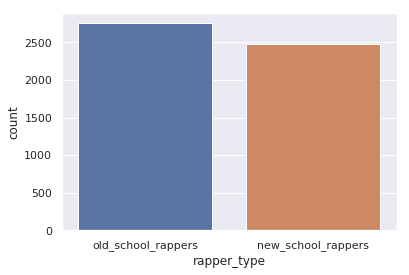

In [6]:
sns.countplot(data=data, x='rapper_type');

There is a little more old school rappers lyrics than new school ones but **it's not that significant**.

### But wait a minute ! Who are the rappers?

In [7]:
for school in ['new_school_rappers', 'old_school_rappers']:
    rappers_songs = data[data.rapper_type == school].artist.value_counts()
    print(f"These are the {len(rappers_songs)} {school} and how much songs they have:")
    print(rappers_songs)
    print('\n')

These are the 28 new_school_rappers and how much songs they have:
Fetty Wap             100
Lil Uzi Vert           99
Lupe Fiasco            98
Schoolboy Q            98
Joey Bada$$            97
Tyler, the Creator     95
Travis Scott           95
Logic                  94
Mac Miller             94
Future                 93
Drake                  93
LIL PUMP               93
Big Sean               93
A$AP Rocky             93
Nicki Minaj            92
J. Cole                92
Wiz Khalifa            92
Cardi B                91
Chance The Rapper      91
Lil Wayne              87
Pusha-T                87
The Game               86
Joyner Lucas           81
2 Chainz               80
Kendrick Lamar         77
Kanye West             72
Rick Ross              68
Rae Sremmurd           45
Name: artist, dtype: int64


These are the 32 old_school_rappers and how much songs they have:
2pac                    100
Mobb Deep                99
Jay-Z                    99
Ice-T                    98

## Cleaning the lyrics:
After I've viewd some lyrics I have some notes about cleaning the data:
1. The rappers names are writen between square brackets - "[]". **We would like to delete this.**
2. Sometimes we can see lyrics between brackets. Sometimes it is part of the song but sometimes it's not. **I'm not sure we'll delete this just yet**
3. There is a lot of spelling errors and slang abbreviations!
4. There are some real stange lyrics which I'm not sure how We got them, like lyrics with full Asian or Arabic charachters, lyrics with no words or a line that sais there is no lyrics etc. **We'll try to locate them and delete them**

The next line of code generates a random line in data.<br/>
Then we print it's lyrics and it's url (no real need for this url but It can help if you want to view more about the lyrics)

In [8]:
random_url, random_lyrics = data[['song_url', 'lyrics']].sample(1).values[0]
print(random_url)
print(random_lyrics)

https://genius.com/Busta-rhymes-calm-down-instrumentals-lyrics


[Instrumental]

[Produced by Scoop Deville]




# Find ood lyrics
maybe 'skit' 'Snippet', 'Remix' and such...

In [10]:
# This function gets a raw lyrics string and returns it cleaned after the steps described:
def clean_song_lyrics(raw_song_lyrics):
    # lower-case all lyrics:
    song_lyrics = str(raw_song_lyrics).lower()
    # Remove text between brackets: (I'm not sure this is a good idea, Let's look at this) #todo: ?
    song_lyrics = re.sub(r'\([^\(\)]+\)', '', song_lyrics)
    # Change "$" in a middle of a word to "s":
    song_lyrics = re.sub(r'\w(\$)\w', 's', song_lyrics)
    # all the I'm combinations we will convert to "I am". It seems "I" is something significant:
    song_lyrics = re.sub(r"[\s\b](i.m)[\s\b]", 'i am', song_lyrics)
    # Remove irrelevant text between square brackets like rappers names and verse number ...:
    song_lyrics = re.sub(r'\[[^\[\]]+\]', '', song_lyrics)
    # Remove anything that is not a word, a number or white-space (like ' and ?)
    song_lyrics = re.sub('[^\w\s]', '', song_lyrics)
    return song_lyrics

In [20]:
data['clean_lyrics'] = data['lyrics'].apply(clean_song_lyrics)

In [12]:
all_lyrics = ' '.join(data['lyrics']).replace('\n', ' ')
# set(re.findall('\([^\(\)]+\)', all_lyrics))

## Word Cloud
Word cloud is a nice way to plot frequent words

In [13]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def word_cloud_plot(text):
    # Generate a word cloud image
    wordcloud = WordCloud(background_color="white", scale=3).generate(text)

    # Display the generated image:
    # the matplotlib way:
    plt.figure(figsize=(55, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout()

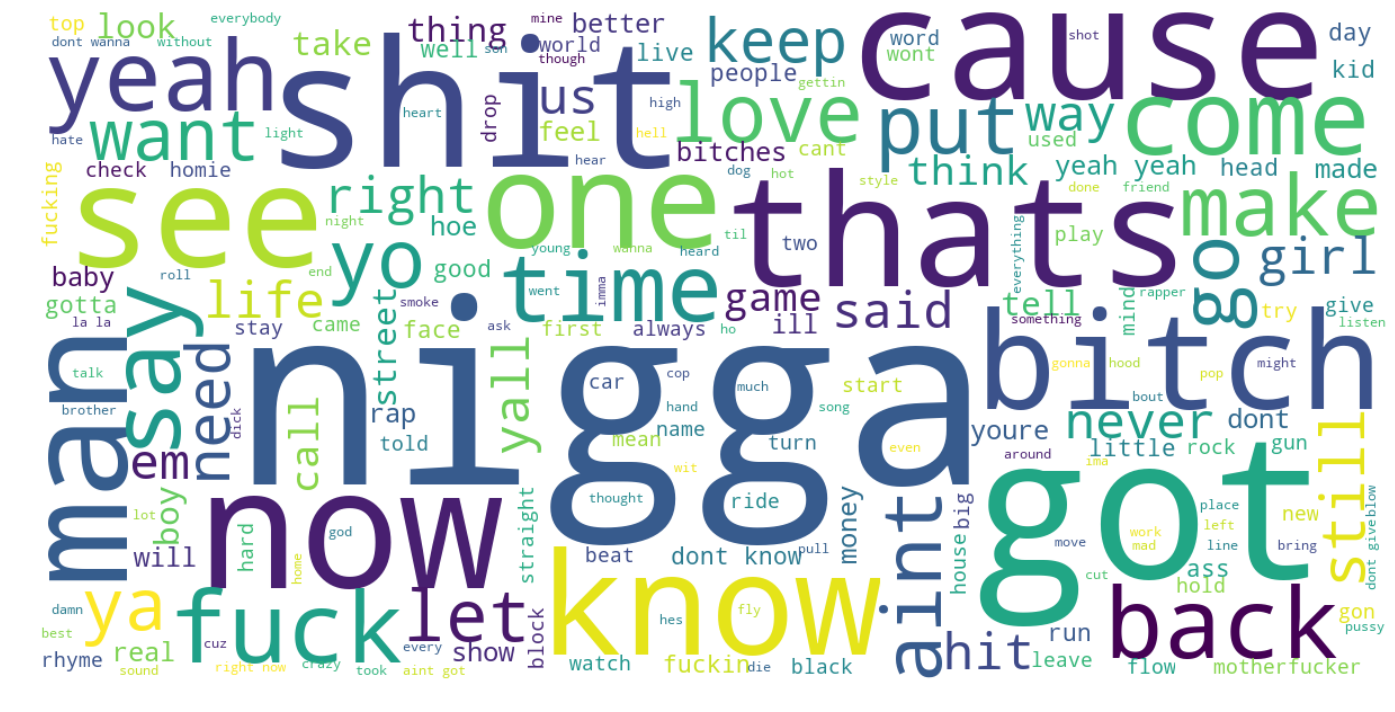

In [14]:
word_cloud_plot(clean_song_lyrics(all_lyrics))

## Is there difference in the legth of the songs?
We will masure length by the number of words

In [21]:
data['word_count'] = data['clean_lyrics'].apply(lambda lyrics: len(lyrics.split()))

In [22]:
data.groupby('rapper_type')['word_count'].agg(['mean', 'median', 'min', 'max'])

,mean,median,min,max
rapper_type,,,,
new_school_rappers,498.782310,463.5,0,6334
old_school_rappers,523.583515,517.5,0,4699


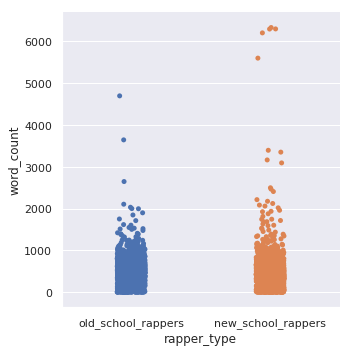

In [23]:
sns.catplot(x="rapper_type", y="word_count", data=data);

Although for now we can't find any real significant difference in the word count, we did found some songs with 0 words in the lyrics. What ?!? A rap song with no words? interesting ... maybe it's an outlier ?

If we have already started talking about outliers, let's look at them a bit more:
# Outliers

Songs with no words (word_count == 0) are outliers for sure, this are just wrong entities. **Let's drop them**<br/>
But what about higher values? or really small ones?

In descriptive statistics, a [box plot](https://en.wikipedia.org/wiki/Box_plot) is a method for graphically depicting groups of numerical data through their quartiles.<br/>
Box plots help us discover outliers in a distribution by a method called [IQR](https://en.wikipedia.org/wiki/Interquartile_range).
The points represent outliers from the IQR calculation:

In [39]:
# Drop no word lyrics and plot the statistics again:
data.drop(data.query('word_count == 0').index, inplace=True)
data.groupby('rapper_type')['word_count'].agg(['mean', 'median', 'min', 'max'])

,mean,median,min,max
rapper_type,,,,
new_school_rappers,502.026423,467.0,1,6334
old_school_rappers,525.491618,519.5,1,4699


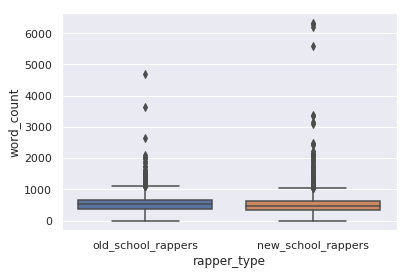

In [40]:
sns.boxplot(x="rapper_type", y="word_count", data=data);

Looks like a song with more than about 1000 words is considered to be an outlier.<br/>
let's plot the boxplot without them and plot them as well:

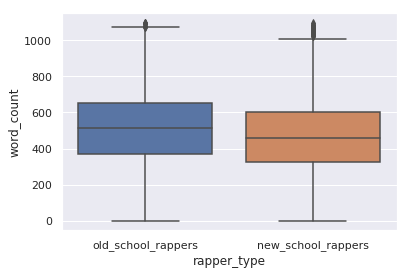

In [38]:
sns.boxplot(x="rapper_type", y="word_count", data=data[data.word_count < 1100]);

In [41]:
data[data.word_count > 1250]

,song_url,lyrics,artist,rapper_type,clean_lyrics,word_count
19,https://genius.com/2pac-2pac-cypher-part-2-lyrics,\n\n[Verse 1 Redman]\n\nTry to O.K. Corral wit...,2pac,old_school_rappers,\n\n\n\ntry to ok corral with doc and meth tic...,1369
91,https://genius.com/2pac-at-a-gun-range-in-comp...,"\n\n[2Pac]: Okay, basically all throughout bei...",2pac,old_school_rappers,\n\n okay basically all throughout being black...,3646
119,https://genius.com/Jay-z-4-44-credits-lyrics,"\n\n1. “Kill Jay Z”\n(S. Carter, D. Wilson, A....",Jay-Z,old_school_rappers,\n\n1 kill jay z\n\nproduced by no id for rich...,1321
126,https://genius.com/Big-l-7-minute-freestyle-ly...,\n\n[Production by Mufi]\n\n[Verse 1: Big L]\n...,Jay-Z,old_school_rappers,\n\n\n\n\nyo i got slugs for snitches no love ...,1505
172,https://genius.com/Jay-z-appearance-on-real-ti...,\n\n[Bill Maher]\nI very often think about you...,Jay-Z,old_school_rappers,\n\n\ni very often think about you and the bea...,2034
202,https://genius.com/Bone-thugs-n-harmony-1st-of...,"\n\n[Hook: Layzie Bone & Bizzy Bone]\nWake up,...",Eazy-E,old_school_rappers,\n\n\nwake up wake up wake up wake up wake up\...,1478
245,https://genius.com/Kokane-dont-bite-the-phunk-...,\n\n[Intro: Answer Phone]\nHello\nYou've reach...,Eazy-E,old_school_rappers,\n\n\nhello\nyouve reach area code 213 291 50 ...,1423
261,https://genius.com/Federal-bureau-of-investiga...,"\n\nDate: 7/21/95\nTo: SAC, LOS ANGELES (28A-L...",Eazy-E,old_school_rappers,\n\ndate 72195\nto sac los angeles \n\nfrom \n...,1998
279,https://genius.com/Bkp-fuck-tha-police-remix-l...,\n\n[Court Officer: D.O.C]\nRight about N.W.A....,Eazy-E,old_school_rappers,\n\n\nright about nwa court is in full effect\...,1287
285,https://genius.com/Tupac-thug-theory-gangsta-r...,\n\n[Verse 1: 2pac]\nI'm livin rough and raw\n...,Eazy-E,old_school_rappers,\n\ni amlivin rough and raw\ncatchin cases at ...,1391


From a quick look at some of the "lyrics" and relevant webpages I saw there is some interviews mixed up in this data. I think we can safely remove all "songs" with 1100 words and above ! (We still have a lot of data so we don't need to mind that so much)

**But what about low count of words?**<br/>
The box plot didn't alert any low count to be an outlier but as I looked at the data I saw there are songs which have it written that there is no lyrics for this song. This kind of songs will have low count of words.
And also which rap song has only one word ?

So even though baced on the IQR calculation there are no low count outliers we would look at some low word count songs:

/home/ariel/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


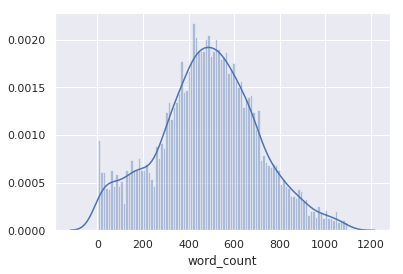

In [46]:
sns.distplot(data[data.word_count < 1100].word_count, bins=100);

/home/ariel/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


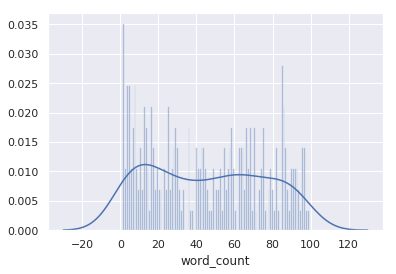

In [51]:
sns.distplot(data[data.word_count < 100].word_count, bins=100);

In [52]:
data[data.word_count < 100]

,song_url,lyrics,artist,rapper_type,clean_lyrics,word_count
5,https://genius.com/2pac-1-for-april-annotated,\n\n2 me your name alone is poetry\nI barely k...,2pac,old_school_rappers,\n\n2 me your name alone is poetry\ni barely k...,87
6,https://genius.com/2pac-1st-impression-annotated,\n\nJust when I thought I'd seen it all\nour p...,2pac,old_school_rappers,\n\njust when i thought id seen it all\nour pa...,93
7,https://genius.com/2pac-1st-impressions-4-iren...,\n\nJust when I thought I'd seen it all\nour p...,2pac,old_school_rappers,\n\njust when i thought id seen it all\nour pa...,93
43,https://genius.com/2pac-2pacs-tattoos-annotated,"\n\nA body map of 2Pac's tattoos, starting fro...",2pac,old_school_rappers,\n\na body map of 2pacs tattoos starting from ...,79
45,https://genius.com/2pac-2-people-with-1-wish-a...,\n\nThere were 2 people with one wish\n2 Live ...,2pac,old_school_rappers,\n\nthere were 2 people with one wish\n2 live ...,79
52,https://genius.com/2pac-a-different-love-annot...,\n\nI remember when you were lost\nand your so...,2pac,old_school_rappers,\n\ni remember when you were lost\nand your so...,70
58,https://genius.com/2pac-album-outro-lyrics,\n\n[Outro]\nExpect me nigga like you expect J...,2pac,old_school_rappers,\n\n\nexpect me nigga like you expect jesus to...,28
64,https://genius.com/2pac-all-eyez-on-me-credits...,\n\nDISC ONE\n\n1. AMBITIONZ AZ RIDAH 4:39...,2pac,old_school_rappers,\n\ndisc one\n\n1 ambitionz az ridah 439\n...,60
69,https://genius.com/2pac-a-love-unspoken-annotated,\n\nWhat of a love unspoken? Is it weaker with...,2pac,old_school_rappers,\n\nwhat of a love unspoken is it weaker witho...,90
71,https://genius.com/2pac-ambition-over-adversit...,\n\nTake ones adversity\nLearn from their misf...,2pac,old_school_rappers,\n\ntake ones adversity\nlearn from their misf...,25


There can be other outliers like lyrics with no english (I saw at least one like this)

In [67]:
no_english_lyrics = data[~data.lyrics.str.contains(r'[A-Za-z]')]
no_english_lyrics

,song_url,lyrics,artist,rapper_type,clean_lyrics,word_count


In [66]:
data.drop(no_english_lyrics.index, inplace=True)

So after all the cleaning we gor from __ song lyrics to __ .

I think it's time to start building our model

# ML model building

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.feature_extraction import text
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from ariels_utils import MLTester

In [ ]:
X = data['clean_lyrics']
y = data['rapper_type']

In [ ]:
model = Pipeline(
        [
#             ('clening', FunctionTransformer(clean_song_lyrics, validate=False)),
            ('vec', text.TfidfVectorizer(binary=True, stop_words='english')),
            ('logreg', LogisticRegression())
        ]
    )

In [ ]:
MLTester(model, X, y, scoring_method='f1_weighted', n_jobs=3, splitting_method=RepeatedStratifiedKFold,
         splitting_method_params={'n_splits': 5}).run()

I did a Repeated Stratified KFold test with 5 fold which where repeated 10 times (total 50 runs). The score std is very small (about 1% in the test sets). <br/>

This indicates that there is no much overall variance in our data (at least it doesn't influence our model) and we can use a simple train_test_split to get a better classification report of our predictions:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(metrics.classification_report(y_test, y_pred))

# Interpret the model's decisions

In [ ]:
import eli5
model.fit(X, y)


eli5.show_weights(model)